<a href="http://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project04%20-%20Topic%20Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling on Research Papers

We will do an interesting exercise here—build topic models on past research papers
from the very popular NIPS conference (now known as the NeurIPS conference). The
late professor Sam Roweis compiled an excellent collection of NIPS Conference Papers
from Volume 1 – 12, which you can find at https://cs.nyu.edu/~roweis/data.html.
An interesting fact is that he obtained this by massaging the OCR’d data from NIPS
1-12, which was actually the pre-electronic submission era. Yann LeCun made the data
available. There is an even more updated dataset available up to NIPS 17 at http://
ai.stanford.edu/~gal/data.html. However, that dataset is in the form of a MAT file, so
you might need to do some additional preprocessing before working on it in Python.


# The Main Objective

Considering our discussion so far, our main objective is pretty simple. Given a whole
bunch of conference research papers, can we identify some key themes or topics from
these papers by leveraging unsupervised learning? We do not have the liberty of labeled
categories telling us what the major themes of every research paper are. Besides that, we
are dealing with text data extracted using OCR (optical character recognition). Hence,
you can expect misspelled words, words with characters missing, and so on, which
makes our problem even more challenging

# Download Data and Dependencies

In [1]:
!wget https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
!tar -xzf nips12raw_str602.tgz

--2019-08-04 18:34:55--  https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
Resolving cs.nyu.edu (cs.nyu.edu)... 128.122.49.30
Connecting to cs.nyu.edu (cs.nyu.edu)|128.122.49.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12851423 (12M) [application/x-gzip]
Saving to: ‘nips12raw_str602.tgz’

nips12raw_str602.tg 100%[===================>]  12.26M  14.4MB/s    in 0.9s    

2019-08-04 18:34:56 (14.4 MB/s) - ‘nips12raw_str602.tgz’ saved [12851423/12851423]



In [8]:
!pip install tqdm
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
import os
import numpy as np
import pandas as pd

DATA_PATH = 'nipstxt/'
print(os.listdir(DATA_PATH))

['nips05', 'RAW_DATA_NOTES', 'README_yann', 'nips07', 'idx', 'nips11', 'nips09', 'nips02', 'nips00', 'nips01', 'nips06', 'nips12', 'MATLAB_NOTES', 'nips08', 'nips04', 'nips10', 'nips03', 'orig']


# Load NIPS Research Papers Data

In [3]:
folders = ["nips{0:02}".format(i) for i in range(0,13)]
# Read all texts into a list.
papers = []
for folder in folders:
    file_names = os.listdir(DATA_PATH + folder)
    for file_name in file_names:
        with open(DATA_PATH + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
            data = f.read()
        papers.append(data)
len(papers)

1740

In [4]:
print(papers[0][:1000])

249 
HIERARCHICAL LEARNING CONTROL - 
AN APPROACH WITH NEURON-LIKE ASSOCIATIVE MEMORIES 
E. Ers 
ISRA Systemtechnik GmbH, Sch6fferstr. 15, D-6100 Darmstadt, FRG 
H. Tolle 
TH Darmstadt, Institut fgr Regelungstechnik, 
Schlograben 1, D-6100 Darmstadt, FRG 
ABSTRACT 
Advances in brain theory need two complementary approaches: 
Analytical investigations by in situ measurements and as well syn- 
thetic modelling supported by computer simulations to generate 
suggestive hypothesis on purposeful structures in the neural 
tissue. In this paper research of the second line is described: 
Starting from a neurophysiologically inspired model of stimulus- 
response (S-R) and/or associative memorization and a psychological- 
ly motivated ministructure for basic control tasks, pre-conditions 
and conditions are studied for cooperation of such units in a 
hierarchical organisation, as can be assumed to be the general 
layout of macrostructures in the brain. 
I. INTRODUCTION 
Theoretic modelling in b

# Basic Text Pre-processing

We perform some basic text wrangling or preprocessing before diving into topic
modeling. We keep things simple here

In [9]:
%%time
import nltk
import tqdm

stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in tqdm.tqdm(papers):
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
            
    return norm_papers
    
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

100%|██████████| 1740/1740 [00:43<00:00, 40.23it/s]

1740
CPU times: user 41.8 s, sys: 1.25 s, total: 43.1 s
Wall time: 43.3 s


In [10]:
print(norm_papers[0][:50])

['hierarchical', 'learning', 'control', 'approach', 'neuron', 'like', 'associative', 'memory', 'er', 'isra', 'systemtechnik', 'gmbh', 'sch6fferstr', 'darmstadt', 'frg', 'tolle', 'th', 'darmstadt', 'institut', 'fgr', 'regelungstechnik', 'schlo', 'graben', 'darmstadt', 'frg', 'abstract', 'advance', 'brain', 'theory', 'need', 'two', 'complementary', 'approach', 'analytical', 'investigation', 'situ', 'measurement', 'well', 'syn', 'thetic', 'modelling', 'supported', 'computer', 'simulation', 'generate', 'suggestive', 'hypothesis', 'purposeful', 'structure', 'neural']


# Build a Bi-gram Phrase Model

Before feature engineering and vectorization, we want to extract some useful bi-gram
based phrases from our research papers and remove some unnecessary terms. We
leverage the very useful gensim.models.Phrases class for this. This capability helps us
automatically detect common phrases from a stream of sentences, which are typically
multi-word expressions/word n-grams. 

This implementation draws inspiration
from the famous paper by Mikolov, et al., “Distributed Representations of Words and
Phrases and their Compositionality,” which you can check out at https://arxiv.org/
abs/1310.4546. We start by extracting and generating words and bi-grams as phrases for
each tokenized research paper. 

We leverage the `min_count` parameter, which tells us that our model ignores all words and bi-grams with total
collected count lower than 20 across the corpus (of the input paper as a list of tokenized
sentences). We also use a `threshold` of 20, which tells us that the model accepts specific
phrases based on this threshold value so that a phrase of words a followed by b is
accepted if the score of the phrase is greater than the threshold of 20. This threshold is
dependent on the scoring parameter, which helps us understand how these phrases are
scored to understand their influence.
Typically the default scorer is used and it’s pretty straightforward to understand.
You can check out further details in the documentation at https://radimrehurek.com/
gensim/models/phrases.html#gensim.models.phrases.original_scorer and in the
previously mentioned research paper.

In [11]:
import gensim

bigram = gensim.models.Phrases(norm_papers, min_count=20, threshold=20, delimiter=b'_') # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[norm_papers[0]][:50])

['hierarchical', 'learning', 'control', 'approach', 'neuron', 'like', 'associative_memory', 'er', 'isra', 'systemtechnik', 'gmbh', 'sch6fferstr', 'darmstadt', 'frg', 'tolle', 'th', 'darmstadt', 'institut', 'fgr', 'regelungstechnik', 'schlo', 'graben', 'darmstadt', 'frg', 'abstract', 'advance', 'brain', 'theory', 'need', 'two', 'complementary', 'approach', 'analytical', 'investigation', 'situ', 'measurement', 'well', 'syn', 'thetic', 'modelling', 'supported', 'computer_simulation', 'generate', 'suggestive', 'hypothesis', 'purposeful', 'structure', 'neural', 'tissue', 'paper']


In [12]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, '1st'), (1, '2nd'), (2, '2sec'), (3, '4th'), (4, '9a'), (5, '9b'), (6, '9th'), (7, 'ability'), (8, 'abstract'), (9, 'abstraction'), (10, 'accept'), (11, 'accordingly'), (12, 'achieved'), (13, 'achieving'), (14, 'aci')]
Total Vocabulary Size: 78892


Looks like we have a lot of unique phrases in our corpus of research papers,
based on the preceding output. Several of these terms are not very useful since they are
specific to a paper or even a paragraph in a research paper. Hence, it is time to prune
our vocabulary and start removing terms. Leveraging document frequency is a great way
to achieve this. 

In [13]:
# Filter out words that occur less than 20 documents, or more than 60% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 7756


We removed all terms that occur fewer than 20 times across all documents and all
terms that occur in more than 60% of all the documents. We are interested in finding
different themes and topics and not recurring themes. Hence, this suits our scenario
perfectly.

# Transforming corpus into bag of words vectors

We can now perform feature engineering by leveraging a simple Bag of Words
model.

In [14]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(4, 1), (5, 1), (15, 6), (16, 4), (27, 1), (31, 1), (32, 1), (35, 4), (39, 1), (41, 1), (43, 1), (60, 1), (75, 9), (76, 1), (78, 2), (85, 10), (87, 29), (89, 7), (90, 3), (91, 1), (93, 9), (98, 1), (109, 3), (114, 1), (115, 5), (118, 1), (120, 3), (123, 1), (125, 3), (126, 1), (128, 1), (129, 1), (132, 2), (140, 9), (141, 1), (147, 3), (153, 3), (154, 1), (155, 4), (157, 3), (164, 1), (169, 2), (170, 1), (177, 3), (178, 3), (179, 1), (180, 2), (181, 1), (186, 2), (190, 1)]


In [15]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[1][:50]])

[('ability', 1), ('abstract', 1), ('activity', 6), ('actual', 4), ('allow', 1), ('american_institute', 1), ('amount', 1), ('another', 4), ('application', 1), ('argument', 1), ('aspect', 1), ('basic', 1), ('brain', 9), ('build', 1), ('built', 2), ('capability', 10), ('cell', 29), ('cerebral', 7), ('cerebral_cortex', 3), ('certain', 1), ('change', 9), ('characterized', 1), ('combination', 3), ('complete', 1), ('complex', 5), ('composed', 1), ('computer_simulation', 3), ('conference', 1), ('connected', 3), ('connection', 1), ('consideration', 1), ('considered', 1), ('control', 2), ('cortical', 9), ('could', 1), ('defined', 3), ('design', 3), ('detail', 1), ('detailed', 4), ('development', 3), ('direction', 1), ('distributed', 2), ('distribution', 1), ('dynamic', 3), ('ed', 3), ('edelman', 1), ('effect', 2), ('effective', 1), ('element', 2), ('end', 1)]


In [16]:
print('Total number of papers:', len(bow_corpus))

Total number of papers: 1740


# Topic Models with Latent Semantic Indexing (LSI)


Our first technique is Latent Semantic Indexing (LSI), which was developed in the 1970s
as a statistical technique to correlate semantically linked terms from corpora. LSI is not
just used for text summarization, but also in information retrieval and search. LSI uses
the very popular Singular Value Decomposition (SVD) technique.

The main principle behind LSI is that similar
terms tend to be used in the same context and hence tend to co-occur more. The term
LSI comes from the fact that this technique has the ability to uncover latent hidden terms
that correlate semantically to form topics.

In [17]:
%%time

TOTAL_TOPICS = 10
lsi_bow = gensim.models.LsiModel(bow_corpus, id2word=dictionary, num_topics=TOTAL_TOPICS,
                                 onepass=True, chunksize=1740, power_iters=1000)

CPU times: user 7min 45s, sys: 1min 40s, total: 9min 25s
Wall time: 6min


In [158]:
for topic_id, topic in lsi_bow.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.215*"unit" + 0.212*"state" + 0.187*"training" + 0.177*"neuron" + 0.162*"pattern" + 0.145*"image" + 0.140*"vector" + 0.125*"feature" + 0.122*"cell" + 0.110*"layer" + 0.101*"task" + 0.097*"class" + 0.091*"probability" + 0.089*"signal" + 0.087*"step" + 0.086*"response" + 0.085*"representation" + 0.083*"noise" + 0.082*"rule" + 0.081*"distribution"

Topic #2:
0.487*"neuron" + 0.396*"cell" + -0.257*"state" + 0.191*"response" + -0.187*"training" + 0.170*"stimulus" + 0.117*"activity" + -0.109*"class" + 0.099*"spike" + 0.097*"pattern" + 0.096*"circuit" + 0.096*"synaptic" + -0.095*"vector" + 0.090*"signal" + 0.090*"firing" + 0.088*"visual" + -0.084*"classifier" + -0.083*"action" + -0.078*"word" + 0.078*"cortical"

Topic #3:
-0.627*"state" + 0.395*"image" + -0.219*"neuron" + 0.209*"feature" + -0.188*"action" + 0.137*"unit" + 0.131*"object" + -0.130*"control" + 0.129*"training" + -0.109*"policy" + 0.103*"classifier" + 0.090*"class" + -0.081*"step" + -0.081*"dynamic" + 0.080*"classifica

Let’s take a moment to understand these results. A brief recap on the LSI model—
it is based on the principle that words that are used in the same contexts tend to have
similar meanings. You can observe in this output that each topic is a combination
of terms (which basically tend to convey an overall sense of the topic) and weights.
Now the problem here is that we have both positive and negative weights. What does
that mean?

Based on existing research and my interpretations, considering we are reducing
the dimensionality here to a 10-dimensional space based on the number of topics, the
sign on each term indicates a sense of direction or orientation in the vector space for a
particular topic. The higher the weight, the more important the contribution. So similar
correlated terms have the same sign or direction. Hence, it is perfectly possible for a
topic to have two different sub-themes based on the sign or orientation of terms. 

In [159]:
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    for term, wt in lsi_bow.show_topic(n, topn=20):
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()

Topic #1:
Direction 1: [('unit', 0.215), ('state', 0.212), ('training', 0.187), ('neuron', 0.177), ('pattern', 0.162), ('image', 0.145), ('vector', 0.14), ('feature', 0.125), ('cell', 0.122), ('layer', 0.11), ('task', 0.101), ('class', 0.097), ('probability', 0.091), ('signal', 0.089), ('step', 0.087), ('response', 0.086), ('representation', 0.085), ('noise', 0.083), ('rule', 0.082), ('distribution', 0.081)]
--------------------------------------------------
Direction 2: []
--------------------------------------------------

Topic #2:
Direction 1: [('neuron', 0.487), ('cell', 0.396), ('response', 0.191), ('stimulus', 0.17), ('activity', 0.117), ('spike', 0.099), ('pattern', 0.097), ('circuit', 0.096), ('synaptic', 0.096), ('signal', 0.09), ('firing', 0.09), ('visual', 0.088), ('cortical', 0.078)]
--------------------------------------------------
Direction 2: [('state', -0.257), ('training', -0.187), ('class', -0.109), ('vector', -0.095), ('classifier', -0.084), ('action', -0.083), ('w

Does this make things better? Well, it’s definitely a lot better than the previous
interpretation. Here we can see clear themes of modeling being applied in chips and
electronic devices, classification and recognition models, neural models talking about
the human brain components like cells, stimuli, neurons, cortical components, and
even themes around reinforcement learning! 

# Understanding LSI and SVD


![](https://i.imgur.com/BglSwGK.png)


![](https://i.imgur.com/nJc79tK.png)

- __M__ is typically known as the term-document matrix and is usually
obtained after feature engineering on the preprocessed text data,
where each row of the matrix represents a term and each column
represents a text document.

- __U__ is known as the term-topic matrix where each row of the matrix
represents a term and each column represents a topic. It’s useful for
getting the influential terms for each topic when we multiply this by
the singular values.

- __S__ is the matrix or array that consists of the list of singular values
obtained after low-rank SVD, which is typically equal to the number
of topics we decide prior to this operation.

- __VT__ is the topic-document matrix, which if you transpose, you get
the document-topic matrix, which is useful in knowing how much
influence each topic has on each document.

### Let’s try to get the three major matrices (U, S, and VT) from our topic model, which uses SVD.

In [160]:
term_topic = lsi_bow.projection.u
singular_values = lsi_bow.projection.s
topic_document = (gensim.matutils.corpus2dense(lsi_bow[bow_corpus], len(singular_values)).T / singular_values).T
term_topic.shape, singular_values.shape, topic_document.shape

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


((7756, 10), (10,), (10, 1740))

Just like the preceding output shows, we have a term-topic matrix, singular values, and a
topic-document matrix. We can transpose the topic-document matrix to form a documenttopic matrix and that would help us see the proportion of each topic per document (a larger
proportion means the topic is more dominant in the document). 

In [161]:
document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_topics.head(15)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,0.027,0.006,-0.016,0.001,-0.012,0.006,0.001,-0.029,-0.026,-0.025
1,0.033,0.071,-0.017,0.003,0.018,0.009,0.020,0.019,0.011,-0.011
2,0.041,-0.014,-0.017,-0.032,-0.018,-0.003,-0.062,-0.005,0.001,0.021
3,0.040,-0.046,-0.121,0.017,-0.071,0.003,0.030,0.027,-0.004,-0.022
4,0.019,0.006,-0.003,-0.000,0.005,0.011,-0.017,0.007,-0.005,0.011
5,0.054,0.102,-0.009,-0.019,-0.006,0.067,0.044,-0.004,0.082,-0.056
6,0.015,0.023,-0.010,-0.005,0.010,-0.013,-0.001,0.005,-0.004,0.004
7,0.013,0.035,-0.010,0.009,0.014,-0.026,0.005,-0.002,0.018,-0.012
8,0.055,-0.006,0.017,-0.086,-0.105,-0.022,-0.030,-0.002,0.005,-0.037
9,0.061,0.004,0.048,-0.127,-0.050,-0.027,-0.063,0.116,0.026,0.061


### Most dominant topics for some sample reviews

In [175]:
sample_paper_patterns = ['Feudal Reinforcement Learning \nPeter', 'Illumination-Invariant Face Recognition with a', 'Improved Hidden Markov Model Speech Recognition']
sample_paper_idxs = [idx for pattern in sample_paper_patterns 
                            for idx, content in enumerate(papers) 
                                if pattern in content]
sample_paper_idxs

[693, 708, 460]

In [176]:
document_numbers = sample_paper_idxs

for document_number in document_numbers:
    top_topics = list(document_topics.columns[np.argsort(-np.absolute(document_topics.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()

Document #693:
Dominant Topics (top 3): ['T5', 'T3', 'T10']
Paper Summary:
Feudal Reinforcement Learning 
Peter Dayan 
CNL 
The Salk Institute 
PO Box 85800 
San Diego CA 92186-5800, USA 
dayanhelmholtz. sdsc. edu 
Geoffrey E Hinton 
Department of Computer Science 
University of Toronto 
6 Kings College Road, Toronto, 
Canada M5S 1A4 
hintonai. toronto. edu 
Abstract 
One way to speed up reinforcement learning is to enable learning to 
happen simultaneously at multiple resolutions in space and time. 
This paper shows how to create a Q-learning managerial hierarchy 
i

Document #708:
Dominant Topics (top 3): ['T4', 'T3', 'T5']
Paper Summary:
Illumination-Invariant Face Recognition with a 
Contrast Sensitive Silicon Retina 
Joachim M. Buhmann 
Rheinische Friedrich-Wilhelms-Universitfit 
Institut ftir Informatik II, R6merstrage 164 
D-53117 Bonn, Germany 
Martin Lades 
Ruhr-Universitfit Bochum 
Institut ftir Neuroinformatik 
D-44780 Bochum, Germany 
Frank Eeckman 
Lawrence Livermore Nat

# Implementing LSI Models from Scratch

Based on what we mentioned earlier, the heart of LSI models involves Singular Value
Decomposition (SVD). Here, we try to implement an LSI topic model from scratch using
low-rank SVD. The first step in SVD is to get the source matrix, which is typically a term-document matrix. We can obtain it from Gensim by converting the sparse Bag of Words
representation into a dense matrix.

In [194]:
td_matrix = gensim.matutils.corpus2dense(corpus=bow_corpus, num_terms=len(dictionary))
print(td_matrix.shape)
td_matrix

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


(7756, 1740)


array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 3.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 18.,  0.,  4.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [195]:
vocabulary = np.array(list(dictionary.values()))
print('Total vocabulary size:', len(vocabulary))
vocabulary

Total vocabulary size: 7756


array(['1st', '2nd', '4th', ..., 'support_vector', 'mozer_jordan',
       'kearns_solla'], dtype='<U28')

In [196]:
dictionary[10]

'achieving'

#### We now perform low-rank SVD on our term document matrix 

In [197]:
from scipy.sparse.linalg import svds

u, s, vt = svds(td_matrix, k=TOTAL_TOPICS, maxiter=10000)
term_topic = u
singular_values = s
topic_document = vt
term_topic.shape, singular_values.shape, topic_document.shape

((7756, 10), (10,), (10, 1740))

In [198]:
tt_weights = term_topic.transpose() * singular_values[:, None]
tt_weights.shape

(10, 7756)

In [199]:
top_terms = 20
topic_key_term_idxs = np.argsort(-np.absolute(tt_weights), axis=1)[:, :top_terms]
topic_keyterm_weights = np.array([tt_weights[row, columns] 
                             for row, columns in list(zip(np.arange(TOTAL_TOPICS), topic_key_term_idxs))])
topic_keyterms = vocabulary[topic_key_term_idxs]
topic_keyterms_weights = list(zip(topic_keyterms, topic_keyterm_weights))
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    terms, weights = topic_keyterms_weights[n]
    term_weights = sorted([(t, w) for t, w in zip(terms, weights)], 
                          key=lambda row: -abs(row[1]))
    for term, wt in term_weights:
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()

Topic #1:
Direction 1: [('training', 92.618), ('task', 80.732), ('pattern', 70.619), ('classifier', 56.988), ('control', 50.676), ('rule', 45.925), ('action', 41.202), ('neuron', 38.194)]
--------------------------------------------------
Direction 2: [('word', -188.487), ('vector', -85.973), ('node', -54.378), ('recognition', -53.231), ('sequence', -50.351), ('circuit', -45.395), ('cell', -44.811), ('hmm', -34.085), ('character', -34.022), ('chip', -32.161), ('matrix', -32.093), ('structure', -30.993)]
--------------------------------------------------

Topic #2:
Direction 1: [('word', 78.349), ('neuron', 69.793), ('stimulus', 63.233), ('feature', 53.819), ('distribution', 53.119), ('response', 30.954), ('state', 29.343), ('probability', 29.1), ('estimate', 28.908)]
--------------------------------------------------
Direction 2: [('node', -173.276), ('circuit', -92.999), ('chip', -73.593), ('classifier', -58.717), ('current', -55.844), ('voltage', -53.489), ('control', -51.709), ('rul

In [200]:
import pandas as pd

document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_topics.head(15)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,0.025,-0.026,-0.029,-0.001,-0.006,-0.012,-0.001,-0.016,-0.006,0.027
1,0.011,0.011,0.019,-0.020,-0.009,0.018,-0.003,-0.017,-0.071,0.033
2,-0.021,0.001,-0.005,0.062,0.003,-0.018,0.032,-0.017,0.014,0.041
3,0.022,-0.004,0.027,-0.030,-0.003,-0.071,-0.017,-0.121,0.046,0.040
4,-0.011,-0.005,0.007,0.017,-0.011,0.005,0.000,-0.003,-0.006,0.019
5,0.056,0.082,-0.004,-0.044,-0.067,-0.006,0.019,-0.009,-0.102,0.054
6,-0.004,-0.004,0.005,0.001,0.013,0.010,0.005,-0.010,-0.023,0.015
7,0.012,0.018,-0.002,-0.005,0.026,0.014,-0.009,-0.010,-0.035,0.013
8,0.037,0.005,-0.002,0.030,0.022,-0.105,0.086,0.017,0.006,0.055
9,-0.061,0.026,0.116,0.063,0.027,-0.050,0.127,0.048,-0.004,0.061


In [201]:
document_numbers = sample_paper_idxs

for document_number in document_numbers:
    top_topics = list(document_topics.columns[np.argsort(-np.absolute(document_topics.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()

Document #693:
Dominant Topics (top 3): ['T6', 'T1', 'T8']
Paper Summary:
Feudal Reinforcement Learning 
Peter Dayan 
CNL 
The Salk Institute 
PO Box 85800 
San Diego CA 92186-5800, USA 
dayanhelmholtz. sdsc. edu 
Geoffrey E Hinton 
Department of Computer Science 
University of Toronto 
6 Kings College Road, Toronto, 
Canada M5S 1A4 
hintonai. toronto. edu 
Abstract 
One way to speed up reinforcement learning is to enable learning to 
happen simultaneously at multiple resolutions in space and time. 
This paper shows how to create a Q-learning managerial hierarchy 
i

Document #708:
Dominant Topics (top 3): ['T7', 'T8', 'T6']
Paper Summary:
Illumination-Invariant Face Recognition with a 
Contrast Sensitive Silicon Retina 
Joachim M. Buhmann 
Rheinische Friedrich-Wilhelms-Universitfit 
Institut ftir Informatik II, R6merstrage 164 
D-53117 Bonn, Germany 
Martin Lades 
Ruhr-Universitfit Bochum 
Institut ftir Neuroinformatik 
D-44780 Bochum, Germany 
Frank Eeckman 
Lawrence Livermore Nati

# Topic Models with Latent Dirichlet Allocation (LDA)

The Latent Dirichlet Allocation (LDA) technique is a generative probabilistic model in
which each document is assumed to have a combination of topics similar to a probabilistic
Latent Semantic Indexing model. In this case, the latent topics contain a Dirichlet
prior over them. The math behind in this technique is pretty involved, so we will try to
summarize it since going it specific details is out of the current scope.

![](https://i.imgur.com/l23JAvE.png)

Simplyfying the LDA model process:

![](https://i.imgur.com/0BXCaUi.png)

![](https://i.imgur.com/ioiUAxX.png)

In [202]:
%%time

lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=1740, 
                                   alpha='auto', eta='auto', random_state=42,
                                   iterations=500, num_topics=TOTAL_TOPICS, 
                                   passes=20, eval_every=None)

CPU times: user 1min 52s, sys: 1.94 s, total: 1min 54s
Wall time: 1min 51s


In [203]:
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.022*"image" + 0.009*"object" + 0.008*"feature" + 0.007*"vector" + 0.004*"bit" + 0.004*"pixel" + 0.004*"view" + 0.004*"chip" + 0.004*"search" + 0.004*"processor" + 0.003*"constraint" + 0.003*"code" + 0.003*"region" + 0.003*"parallel" + 0.003*"distance" + 0.003*"solution" + 0.003*"matrix" + 0.003*"surface" + 0.003*"memory" + 0.003*"application"

Topic #2:
0.011*"unit" + 0.009*"structure" + 0.008*"variable" + 0.007*"node" + 0.007*"representation" + 0.006*"tree" + 0.006*"vector" + 0.006*"cluster" + 0.005*"image" + 0.004*"probability" + 0.004*"pattern" + 0.004*"clustering" + 0.004*"level" + 0.004*"feature" + 0.004*"graph" + 0.004*"object" + 0.003*"mixture" + 0.003*"distribution" + 0.003*"layer" + 0.003*"local"

Topic #3:
0.023*"state" + 0.012*"action" + 0.011*"control" + 0.007*"policy" + 0.007*"step" + 0.006*"task" + 0.006*"reinforcement_learning" + 0.005*"optimal" + 0.005*"controller" + 0.005*"environment" + 0.004*"robot" + 0.004*"goal" + 0.004*"reward" + 0.004*"expert" + 0.003

In [204]:
topics_coherences = lda_model.top_topics(bow_corpus, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print('Avg. Coherence Score:', avg_coherence_score)

Avg. Coherence Score: -1.0530915936779408


Topic coherence is a complex topic in its own and it can be used to measure the
quality of topic models to some extent. Typically, a set of statements is said to be
coherent if they support each other. Topic models are unsupervised learning based
models that are trained on unstructured text data, making it difficult to measure the
quality of outputs. 

Refer to Text Analytics with Python 2nd Edition for more detail on this.

In [205]:
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([(term, round(wt, 3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('distribution', 0.007), ('training', 0.007), ('noise', 0.006), ('estimate', 0.005), ('vector', 0.005), ('equation', 0.005), ('approximation', 0.004), ('gaussian', 0.004), ('sample', 0.004), ('prediction', 0.004), ('prior', 0.004), ('density', 0.004), ('linear', 0.004), ('variance', 0.004), ('rate', 0.004), ('average', 0.004), ('matrix', 0.004), ('optimal', 0.003), ('solution', 0.003), ('probability', 0.003)]

Topic #2:
[('stimulus', 0.009), ('visual', 0.009), ('motion', 0.009), ('signal', 0.009), ('response', 0.008), ('image', 0.007), ('unit', 0.007), ('filter', 0.007), ('cell', 0.006), ('direction', 0.006), ('map', 0.005), ('spatial', 0.005), ('orientation', 0.004), ('neuron', 0.004), ('receptive_field', 0.004), ('location', 0.004), ('pattern', 0.004), ('noise', 0.004), ('representation', 0.004), ('component', 0.003)]

Topic #3:
[('neuron', 0.022), ('cell', 0.017), ('circuit', 0.009), ('response', 0.007), ('current', 0.007), ('synaptic', 0.006), ('s

In [206]:
print('LDA Topics without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([term for wt, term in topic])
    print()

LDA Topics without Weights
Topic #1:
['distribution', 'training', 'noise', 'estimate', 'vector', 'equation', 'approximation', 'gaussian', 'sample', 'prediction', 'prior', 'density', 'linear', 'variance', 'rate', 'average', 'matrix', 'optimal', 'solution', 'probability']

Topic #2:
['stimulus', 'visual', 'motion', 'signal', 'response', 'image', 'unit', 'filter', 'cell', 'direction', 'map', 'spatial', 'orientation', 'neuron', 'receptive_field', 'location', 'pattern', 'noise', 'representation', 'component']

Topic #3:
['neuron', 'cell', 'circuit', 'response', 'current', 'synaptic', 'spike', 'voltage', 'activity', 'pattern', 'firing', 'chip', 'synapsis', 'connection', 'signal', 'neural', 'stimulus', 'layer', 'effect', 'cortical']

Topic #4:
['training', 'feature', 'word', 'classifier', 'classification', 'recognition', 'pattern', 'class', 'trained', 'task', 'speech', 'test', 'unit', 'training_set', 'character', 'experiment', 'rule', 'face', 'representation', 'layer']

Topic #5:
['class', 'l

## Evaluating topic model quality

We can use perplexity and coherence scores as measures to evaluate the topic
model. Typically, lower the perplexity, the better the model. Similarly, the lower the
UMass score and the higher the Cv score in coherence, the better the model.

In [207]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary, 
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                         texts=norm_corpus_bigrams,
                                                         dictionary=dictionary, 
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.46898489232942786
Avg. Coherence Score (UMass): -1.053091593677941
Model Perplexity: -7.794018299254993


# LDA Models with MALLET

The MALLET framework is a Java-based package for statistical natural language
processing, document classification, clustering, topic modeling, information extraction,
and other machine learning applications to text. MALLET stands for MAchine Learning
for LanguagE Toolkit. It was developed by Andrew McCallum along with several people
at the University of Massachusetts Amherst. The MALLET topic modeling toolkit
contains efficient, sampling-based implementations of Latent Dirichlet Allocation,
Pachinko Allocation, and Hierarchical LDA. To use MALLET’s capabilities, we need to
download the framework.

In [208]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip -q mallet-2.0.8.zip

--2019-08-04 20:34:12--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  13.6MB/s    in 1.1s    

2019-08-04 20:34:14 (13.6 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [211]:
MALLET_PATH = 'mallet-2.0.8/bin/mallet'
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=bow_corpus, 
                                              num_topics=TOTAL_TOPICS, id2word=dictionary,
                                              iterations=500, workers=4)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [212]:
cv_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                             texts=norm_corpus_bigrams,
                                                             dictionary=dictionary, 
                                                             coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda_mallet.get_coherence()

umass_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                                texts=norm_corpus_bigrams,
                                                                dictionary=dictionary,  
                                                                coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda_mallet.get_coherence()

# from STDOUT: <500> LL/token: -8.50105
perplexity = -8.50105
print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.518784549363429
Avg. Coherence Score (UMass): -1.071309554631297
Model Perplexity: -8.50105


# LDA Tuning: Finding the optimal number of topics

Finding the optimal number of topics in a topic model is tough, given that it is like a
model hyperparameter that you always have to set before training the model. We can
use an iterative approach and build several models with differing numbers of topics and
select the one that has the highest coherence score. 

In [0]:
def topic_model_coherence_generator(corpus, texts, dictionary, 
                                    start_topic_count=2, end_topic_count=10, step=1,
                                    cpus=1):
    
    models = []
    coherence_scores = []
    for topic_nums in tqdm.tqdm(range(start_topic_count, end_topic_count+1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=corpus,
                                                            num_topics=topic_nums, id2word=dictionary,
                                                            iterations=500, workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model, corpus=corpus, 
                                                                     texts=texts, dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
    
    return models, coherence_scores

In [214]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                               dictionary=dictionary, start_topic_count=2,
                                                               end_topic_count=30, step=1, cpus=4)

  0%|          | 0/29 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
100%|██████████| 29/29 [1:39:20<00:00, 252.57s/it]


In [215]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
19,21,0.5467
27,29,0.5429
15,17,0.5412
23,25,0.5409
25,27,0.5400
12,14,0.5376
13,15,0.5340
18,20,0.5331
20,22,0.5330
24,26,0.5329


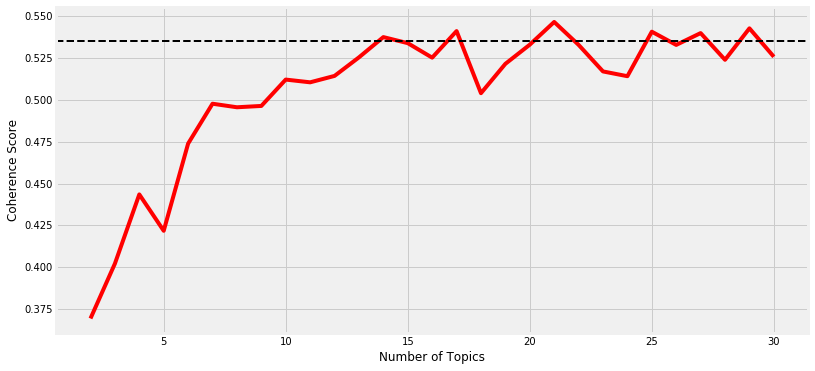

In [216]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(2, 31, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

We choose the optimal number of topics as 20, based on our intuition. We can retrieve the best model now

In [220]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 20].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

20

In [221]:
topics = [[(term, round(wt, 3)) 
               for term, wt in best_lda_model.show_topic(n, topn=20)] 
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['image', 'object', 'feature', 'pixel', 'view', 'face', 'region', 'visual', 'representation', 'surface', 'edge', 'location', 'shape', 'recognition', 'scale', 'contour', 'local', 'part', 'scene', 'vision']

Topic #2:
['equation', 'rate', 'convergence', 'gradient', 'vector', 'optimal', 'iteration', 'eq', 'update', 'constant', 'line', 'gradient_descent', 'rule', 'derivative', 'step', 'minimum', 'approximation', 'change', 'noise', 'adaptive']

Topic #3:
['state', 'action', 'step', 'policy', 'control', 'reinforcement_learning', 'environment', 'optimal', 'task', 'goal', 'reward', 'td', 'agent', 'current', 'machine', 'transition', 'cost', 'reinforcement', 'rl', 'update']

Topic #4:
['training', 'class', 'classification', 'classifier', 'training_set', 'pattern', 'feature', 'test', 'machine', 'sample', 'test_set', 'size', 'trained', 'kernel', 'ensemble', 'table', 'nearest_neighbor', 'margin', 'pruning', 'error_rate']

Topic #5:
['task', 'target', 'rate', 'test', 'curve', 'experiment',

# Viewing LDA Model topics

In [222]:
topics_df = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics], 
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
Term1,image,equation,state,training,task,solution,signal,prediction,dynamic,cell,distribution,vector,neuron,word,circuit,estimate,unit,bound,control,node
Term2,object,rate,action,class,target,constraint,noise,application,state,response,probability,matrix,cell,recognition,chip,estimation,layer,theorem,motion,rule
Term3,feature,convergence,step,classification,rate,local,filter,experiment,memory,stimulus,prior,distance,spike,speech,current,mixture,training,class,position,structure
Term4,pixel,gradient,policy,classifier,test,energy,source,table,pattern,activity,variable,component,synaptic,training,analog,cluster,hidden_unit,size,trajectory,representation
Term5,view,vector,control,training_set,curve,linear,frequency,user,equation,visual,gaussian,code,activity,character,voltage,regression,net,threshold,velocity,tree
Term6,face,optimal,reinforcement_learning,pattern,experiment,optimization,channel,query,neuron,receptive_field,bayesian,transformation,firing,sequence,neuron,variance,pattern,complexity,movement,level
Term7,region,iteration,environment,feature,training,nonlinear,component,time_series,attractor,map,log,linear,response,hmm,bit,expert,architecture,proof,direction,graph
Term8,visual,eq,optimal,test,effect,global,response,variable,capacity,pattern,density,dimensional,synapsis,context,implementation,clustering,activation,loss,motor,symbol
Term9,representation,update,task,machine,random,potential,temporal,sequence,fixed_point,spatial,approximation,map,neural,feature,processor,sample,trained,polynomial,target,sequence
Term10,surface,constant,goal,sample,trial,optimal,auditory,type,noise,unit,entropy,dimension,current,frame,design,kernel,recurrent,linear,controller,string


In [223]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

,Terms per Topic
Topic1,"image, object, feature, pixel, view, face, region, visual, representation, surface, edge, location, shape, recognition, scale, contour, local, part, scene, vision"
Topic2,"equation, rate, convergence, gradient, vector, optimal, iteration, eq, update, constant, line, gradient_descent, rule, derivative, step, minimum, approximation, change, noise, adaptive"
Topic3,"state, action, step, policy, control, reinforcement_learning, environment, optimal, task, goal, reward, td, agent, current, machine, transition, cost, reinforcement, rl, update"
Topic4,"training, class, classification, classifier, training_set, pattern, feature, test, machine, sample, test_set, size, trained, kernel, ensemble, table, nearest_neighbor, margin, pruning, error_rate"
Topic5,"task, target, rate, test, curve, experiment, training, effect, random, trial, generalization, search, instance, size, subject, average, bias, study, human, measure"
Topic6,"solution, constraint, local, energy, linear, optimization, nonlinear, global, potential, optimal, find, minimum, temperature, criterion, principle, search, path, variable, design, maximum"
Topic7,"signal, noise, filter, source, frequency, channel, component, response, temporal, auditory, sound, detection, ica, phase, amplitude, correlation, light, eeg, linear, processing"
Topic8,"prediction, application, experiment, table, user, query, time_series, variable, sequence, type, block, predictor, modeling, future, technique, predictive, predict, series, predicted, protein"
Topic9,"dynamic, state, memory, pattern, equation, neuron, attractor, capacity, fixed_point, noise, phase, hopfield, teacher, theory, stable, student, matrix, delay, symmetric, behavior"
Topic10,"cell, response, stimulus, activity, visual, receptive_field, map, pattern, spatial, unit, orientation, cortical, layer, cortex, center, region, contrast, eye, area, neuron"


# Interpreting Topic Model Results

An interesting point to remember is, given a corpus of documents (in the form of
features, e.g., Bag of Words) and a trained topic model, you can predict the distribution of
topics in each document (research paper in this case).

We can now get the most dominant topic per research paper with some intelligent
sorting and indexing.

In [224]:
tm_results = best_lda_model[bow_corpus]

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [225]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in tm_results]
corpus_topics[:5]

[(18, 0.1888297872340426),
 (12, 0.44786386676321494),
 (5, 0.24530052681992331),
 (2, 0.5155421056564298),
 (8, 0.3266178266178266)]

In [0]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(papers))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = papers

# Dominant Topics Distribution Across Corpus

The first thing we can do is look at the overall distribution of each topic across the corpus
of research papers. Mainly we want to determine the total number of papers and the
total percentage of papers where each of the 20 topics was the most dominant.

In [227]:
pd.set_option('display.max_colwidth', 200)
topic_stats_df = corpus_topic_df.groupby('Dominant Topic').agg({
                                                'Dominant Topic': {
                                                    'Doc Count': np.size,
                                                    '% Total Docs': np.size }
                                              })
topic_stats_df = topic_stats_df['Dominant Topic'].reset_index()
topic_stats_df['% Total Docs'] = topic_stats_df['% Total Docs'].apply(lambda row: round((row*100) / len(papers), 2))
topic_stats_df['Topic Desc'] = [topics_df.iloc[t]['Terms per Topic'] for t in range(len(topic_stats_df))]
topic_stats_df

/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,Dominant Topic,Doc Count,% Total Docs,Topic Desc
0,1,120,6.90,"image, object, feature, pixel, view, face, region, visual, representation, surface, edge, location, shape, recognition, scale, contour, local, part, scene, vision"
1,2,75,4.31,"equation, rate, convergence, gradient, vector, optimal, iteration, eq, update, constant, line, gradient_descent, rule, derivative, step, minimum, approximation, change, noise, adaptive"
2,3,108,6.21,"state, action, step, policy, control, reinforcement_learning, environment, optimal, task, goal, reward, td, agent, current, machine, transition, cost, reinforcement, rl, update"
3,4,88,5.06,"training, class, classification, classifier, training_set, pattern, feature, test, machine, sample, test_set, size, trained, kernel, ensemble, table, nearest_neighbor, margin, pruning, error_rate"
4,5,60,3.45,"task, target, rate, test, curve, experiment, training, effect, random, trial, generalization, search, instance, size, subject, average, bias, study, human, measure"
5,6,36,2.07,"solution, constraint, local, energy, linear, optimization, nonlinear, global, potential, optimal, find, minimum, temperature, criterion, principle, search, path, variable, design, maximum"
6,7,74,4.25,"signal, noise, filter, source, frequency, channel, component, response, temporal, auditory, sound, detection, ica, phase, amplitude, correlation, light, eeg, linear, processing"
7,8,47,2.70,"prediction, application, experiment, table, user, query, time_series, variable, sequence, type, block, predictor, modeling, future, technique, predictive, predict, series, predicted, protein"
8,9,90,5.17,"dynamic, state, memory, pattern, equation, neuron, attractor, capacity, fixed_point, noise, phase, hopfield, teacher, theory, stable, student, matrix, delay, symmetric, behavior"
9,10,116,6.67,"cell, response, stimulus, activity, visual, receptive_field, map, pattern, spatial, unit, orientation, cortical, layer, cortex, center, region, contrast, eye, area, neuron"


# Dominant Topics in Specific Research Papers

Another interesting perspective is to select specific papers, view the most dominant topic
in each of those papers, and see if that makes sense.

In [228]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], 
                                                                                         ascending=False)
                                                                             .iloc[0]))

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
Dominant Topic,,,,,
1,108,1,55.66,"image, object, feature, pixel, view, face, region, visual, representation, surface, edge, location, shape, recognition, scale, contour, local, part, scene, vision",297 \nA NETWORK FOR IMAGE SEGMENTATION \nUSING COLOR \nAnya Hurlbert and Tomaso Poggio \nCenter for Biological Information Processing at Whitaker College \nDepartment of Brain and Cognitive Scienc...
2,1197,2,57.13,"equation, rate, convergence, gradient, vector, optimal, iteration, eq, update, constant, line, gradient_descent, rule, derivative, step, minimum, approximation, change, noise, adaptive","Removing Noise in On-Line Search using \nAdaptive Batch Sizes \nGenevieve B. Orr \nDepartment of Computer Science \nWillamette University \n900 State Street \nSalem, Oregon 97301 \ngorr)willamett..."
3,1158,3,74.16,"state, action, step, policy, control, reinforcement_learning, environment, optimal, task, goal, reward, td, agent, current, machine, transition, cost, reinforcement, rl, update","Reinforcement Learning for Mixed \nOpen-loop and Closed-loop Control \nEric A. Hansen, Andrew G. Barto, and Shlomo Zilbersteln \nDepartment of Computer Science \nUniversity of Massachusetts \nAmhe..."
4,1039,4,66.83,"training, class, classification, classifier, training_set, pattern, feature, test, machine, sample, test_set, size, trained, kernel, ensemble, table, nearest_neighbor, margin, pruning, error_rate","Boosting Decision Trees \nHarris Drucker \nAT&T Bell Laboratories \nHolmdel, New Jersey 07733 \nCorinna Cortes \nAT&T Bell Laboratories \nMurray Hill, New Jersey 07974 \nAbstract \nA new boosting ..."
5,583,5,48.27,"task, target, rate, test, curve, experiment, training, effect, random, trial, generalization, search, instance, size, subject, average, bias, study, human, measure","A Knowledge-Based Model of Geometry Learning \nGeoffrey Towell \nSiemens Corporate Research \n755 College Road East \nPrinceton, NJ 08540 \ntoweli @ learning. siemens. com \nRichard Lehrer \nEduca..."
6,1003,6,50.58,"solution, constraint, local, energy, linear, optimization, nonlinear, global, potential, optimal, find, minimum, temperature, criterion, principle, search, path, variable, design, maximum","Softassign versus Softmax: Benchmarks \nin Combinatorial Optimization \nSteven Gold \nDepartment of Computer Science \nYale University \nNew Haven, CT 06520-8285 \nAnand Rangarajan \nDept. of Diag..."
7,1314,7,56.34,"signal, noise, filter, source, frequency, channel, component, response, temporal, auditory, sound, detection, ica, phase, amplitude, correlation, light, eeg, linear, processing","Extended ICA Removes Artifacts from \nElectroencephalographic Recordings \nTzyy-Ping Jung , Colin Humphries , Te-Won Lee , Scott Makeig 2'3, \nMartin J. McKeown , Vicente Iragui 3, Terrence J...."
8,1276,8,46.83,"prediction, application, experiment, table, user, query, time_series, variable, sequence, type, block, predictor, modeling, future, technique, predictive, predict, series, predicted, protein","Predicting Lifetimes in Dynamically \nAllocated Memory \nDavid A. Cohn \nAdaptive Systems Group \nHarlequin, Inc. \nMenlo Park, CA 94025 \ncohnharlequin. tom \nSatinder Singh \nDepartment of Comp..."
9,168,9,64.30,"dynamic, state, memory, pattern, equation, neuron, attractor, capacity, fixed_point, noise, phase, hopfield, teacher, theory, stable, student, matrix, delay, symmetric, behavior","568 \nDYNAMICS OF ANALOG NEURAL \nNETWORKS WITH TIME DELAY \nC.M. Marcus and R.M. Westervelt \nDivision of Applied Sciences and Department of Physics \nHarvard University, Cambridge Massachusetts ..."


In [229]:
sample_paper_patterns = ['Feudal Reinforcement Learning \nPeter', 'Illumination-Invariant Face Recognition with a', 'Improved Hidden Markov Model Speech Recognition']
sample_paper_idxs = [idx for pattern in sample_paper_patterns 
                            for idx, content in enumerate(papers) 
                                if pattern in content]
sample_paper_idxs

[693, 708, 460]

In [230]:
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df[corpus_topic_df['Document']
                 .isin(sample_paper_idxs)])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
460,460,14,49.04,"word, recognition, speech, training, character, sequence, hmm, context, feature, frame, letter, speaker, state, trained, speech_recognition, phoneme, digit, segmentation, mlp, hybrid","Improved Hidden Markov Model \nSpeech Recognition Using \nRadial Basis Function Networks \nElliot Singer and Richard P. Lippmann \nLincoln Laboratory, MIT \nLexington, MA 02173-9108, USA \nAbstrac..."
693,693,3,47.48,"state, action, step, policy, control, reinforcement_learning, environment, optimal, task, goal, reward, td, agent, current, machine, transition, cost, reinforcement, rl, update","Feudal Reinforcement Learning \nPeter Dayan \nCNL \nThe Salk Institute \nPO Box 85800 \nSan Diego CA 92186-5800, USA \ndayanhelmholtz. sdsc. edu \nGeoffrey E Hinton \nDepartment of Computer Scien..."
708,708,1,38.37,"image, object, feature, pixel, view, face, region, visual, representation, surface, edge, location, shape, recognition, scale, contour, local, part, scene, vision","Illumination-Invariant Face Recognition with a \nContrast Sensitive Silicon Retina \nJoachim M. Buhmann \nRheinische Friedrich-Wilhelms-Universitfit \nInstitut ftir Informatik II, R6merstrage 164 ..."
